# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **Practice III - Retail score analysis**
#### <p style="text-align:center"> **Machine Learning**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>
    
<p style="text-align:left">Mario Sabater Pascual - <font color='orange'>mario.sabater@cunef.edu </font>

![Highway](https://www.restaurant-hospitality.com/sites/restaurant-hospitality.com/files/styles/article_featured_retina/public/uploads/2013/07/yelplogopromo.jpg?itok=OM0azJTj)

In this Machine Learning practice we will be working with the **Yelp dataset**. The whole practice will be composed by the following notebooks:

 0. Data Reading and Problem statement
 1. <font color='darkgreen'>**Data selection & variables preparation**</font>
 2. EDA
 3. Model selection
 4. Best Model and Explainability
 5. Variables Relationship (Graphs)

In this notebook, and after we have selected the problem to predict through machine learning, we need to select the valuable and useful data the available in the yelp dataset. Then we will go through the variables from the selected data and prepare them for our models and EDA.

 - [Libraries import](#0) 
 - [Functions used in this notebook](#1) 
 - [Data Selection](#2) 
     - [States](#2.1)
     - [Type of Business](#2.2)
 - [Variables preparation](#3) 
     - [Attributes](#3.1) 
     - [Categories](#3.2)   
     - [hours](#3.3)
 - [Star Variable modification](#4) 
 - [Selected data export](#5)

##  <a name="0"> Libraries import</a>

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import math
import ast

import warnings
warnings.filterwarnings('ignore')

##  <a name="1"> Functions used in this notebook</a>

In [2]:
def extract_true_values(d):
  # If d is None, return 'None'
  if d is None:
    return 'None'
  # Create a list of keys in d whose values are True
  true_values = [k for k, v in d.items() if v]
  # Join the keys with '+' and return the resulting string
  return '+'.join(true_values)

We will use this function in order to modify the parking attribute in the business. The parking attribute has a format of "None" or a dictionary where the keys are the five tipes of parking and the values of such keys are true or false.

This function yields the true values of the dictionary if any, and if more than one separated by a "+". If the value is "None" or all the values of the dictionary are False, it will also yield "None"

In [3]:
def extract_hours_info(s):
    # If s is None, return two NaN values
    if s is None:
        return np.nan, np.nan
    # Split s into open and close hours
    open_hour, close_hour = s.split('-')
    # Convert the open hour to a decimal hour representation
    open_hour = int(open_hour.split(':')[0]) + int(open_hour.split(':')[1]) / 60
    # Convert the close hour to a decimal hour representation
    close_hour = int(close_hour.split(':')[0]) + int(close_hour.split(':')[1]) / 60
    # Return the open and close hours
    return open_hour, close_hour

def count_days(row):
    # If row is None, return a NaN value
    if row is None:
        return np.nan
    # Initialize the number of days to 0
    days = 0
    # Iterate over the key-value pairs in row
    for day, s in row.items():
        # Extract the open and close hours
        open_hour, close_hour = extract_hours_info(s)
        # If the open and close hours are not equal, increment the number of days
        if open_hour != close_hour:
            days += 1
    # If all days are closed, return 7
    if days == 0:
        return 7
    # Otherwise, return the number of days
    return days

def count_hours(row):
    # If row is None, return a NaN value
    if row is None:
        return np.nan
    # Initialize the number of hours to 0
    hours = 0
    # Iterate over the key-value pairs in row
    for day, s in row.items():
        # Extract the open and close hours
        open_hour, close_hour = extract_hours_info(s)
        # Add the difference between the close hour and the open hour to the number of hours
        hours += close_hour - open_hour
    # If all days are closed, return 168
    if hours == 0:
        return 168
    # Otherwise, return the number of hours
    return abs(hours)

Due to the format of the variable hours in the business dataset (the same as the parking) where it can be "None" or a dictionary with keys as the days opened and values as the time spam the business is opened, we will use the three functions to obtain valuable data. 

The **extract_hours_info** function takes a string s as input and returns two values representing the open and close hours in decimal hour format.

The **count_days** function takes a row as input, and returns the number of days that the business is open, based on the open and close hours for each day.

Similar to the one just mentioned, the **count_hours** function takes a row  as input and returns the number of hours that the business is open, based on the open and close hours for each day.

Whenever business in the hours variable has this: _{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'Wednesday': '0:0-0:0', 'Thursday': '0:0-0:0', 'Friday': '0:0-0:0', 'Saturday': '0:0-0:0', 'Sunday': '0:0-0:0'}_ The functions will yield 7 days and 168 hours, as we undstand the business is opened 24 hours.

##  <a name="2"> Data Selection</a>

Given the fact that the prediction we will make in the following notebooks is **if a restaurant business would be successsfull (4 or more stars on average) given its characteristics and in a representative number of states, the data we will be using is the one stored under the business json**.

As we observed in the previous notebook (_same graph as following_), the number of states is not balanced. Since we try to have a representative number of states of the US, we will have in our final dataset some from each coast, as well as from the interior states North and South ones. This is because the demography, culture, economics, etc. are completely different between the regions, hence the different tastes and, of course, reviews. 

###  <a name="2.1"> States</a>

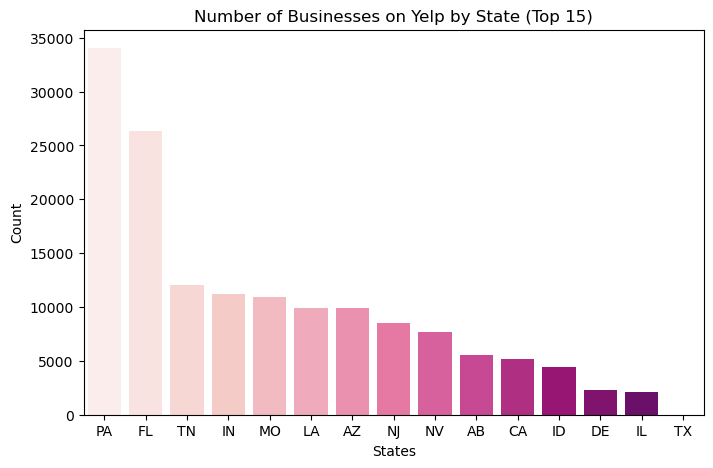

In [4]:
state_counts = {}
states = []
# Open the JSON file
with open('../data/raw/yelp_academic_dataset_business.json', 'r') as f:
    # Read the file line by line
    for line in f:
        # Parse each line as a JSON object
        data = json.loads(line)
        # Extract the relevant data from the JSON object
        states.append(data['state'])
        # Count the number of occurrences of each state
        if data['state'] not in state_counts:
            state_counts[data['state']] = 1
        else:
            state_counts[data['state']] += 1

# Sort the state counts in descending order and select the top 15 states
top15_states = sorted(state_counts, key=state_counts.get, reverse=True)[:15]
top15_counts = [state_counts[state] for state in top15_states]

# Create a Pandas DataFrame with the top 15 states and their counts
top15 = pd.DataFrame({'state': top15_states, 'count': top15_counts})

# Plot the barplot using the DataFrame
plt.figure(figsize=(8,5))
ax = sns.barplot(x='state',y='count', data=top15, palette='RdPu')
ax.set_ylabel('Count')
ax.set_xlabel('States')
ax.set_title('Number of Businesses on Yelp by State (Top 15)')
                
plt.show()

In order to comply with the aforementioned, We select:
 - PA. Pennsylvania (Northen East Coast)
 - FL. Florida (Southen East Coast)
 - TN. Tennessee (Interior East)
 - MO. Missouri (Central US)
 - LA. Louisiana (South US)
 - AZ. Arizona (Interior West Coast)
 - CA. California (West Coast)
 - ID. Idaho (Northen West Coast)
 
**Now that we have reduced our business dataset, we compile this information in a pandas dataframe in order to work with it.**

In [5]:
# List of states to include in the dataframe
states_selected= ["PA", "FL", "TN", "MO", "LA", "AZ", "CA", "ID"]

# Create an empty list to store the JSON objects
json_list = []

# Open the JSON file in read mode
with open('../data/raw/yelp_academic_dataset_business.json', 'r') as f:
    # Iterate over the lines in the file
    for line in f:
        # Load the line as a JSON object
        obj = json.loads(line)
        # If the object has the key 'state' with a value in the states_selected list, add it to the list
        if obj['state'] in states_selected:
            json_list.append(obj)

# Create a DataFrame from the list of JSON objects
business_selected_states = pd.DataFrame(json_list)

business_selected_states.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


###  <a name="2.2"> Type of business</a>

Given the characteristics of the dataset and as we have seen in the first 5 rows of the business dataset, there are a huge number of different business types. 

Only looking at the first five rows of the business dataset, we can see a different number of sectors such as doctors, restaurants, shipping centers, etc. This high variety can make our model less efficient. Hence we will be focusing in an industry.

In [6]:
business_cats=', '.join(business_selected_states['categories'].dropna())
cats=pd.DataFrame(business_cats.split(', '),columns=['category'])
cats_ser = cats.category.value_counts()
cats_df = pd.DataFrame(cats_ser)
cats_df.reset_index(inplace=True)
print("In the selected states, There are " + str(len(cats)) + " different categories")

In the selected states, There are 505342 different categories


With this amount of categories, seems reasonable to take a look at the top 20 most common categories.

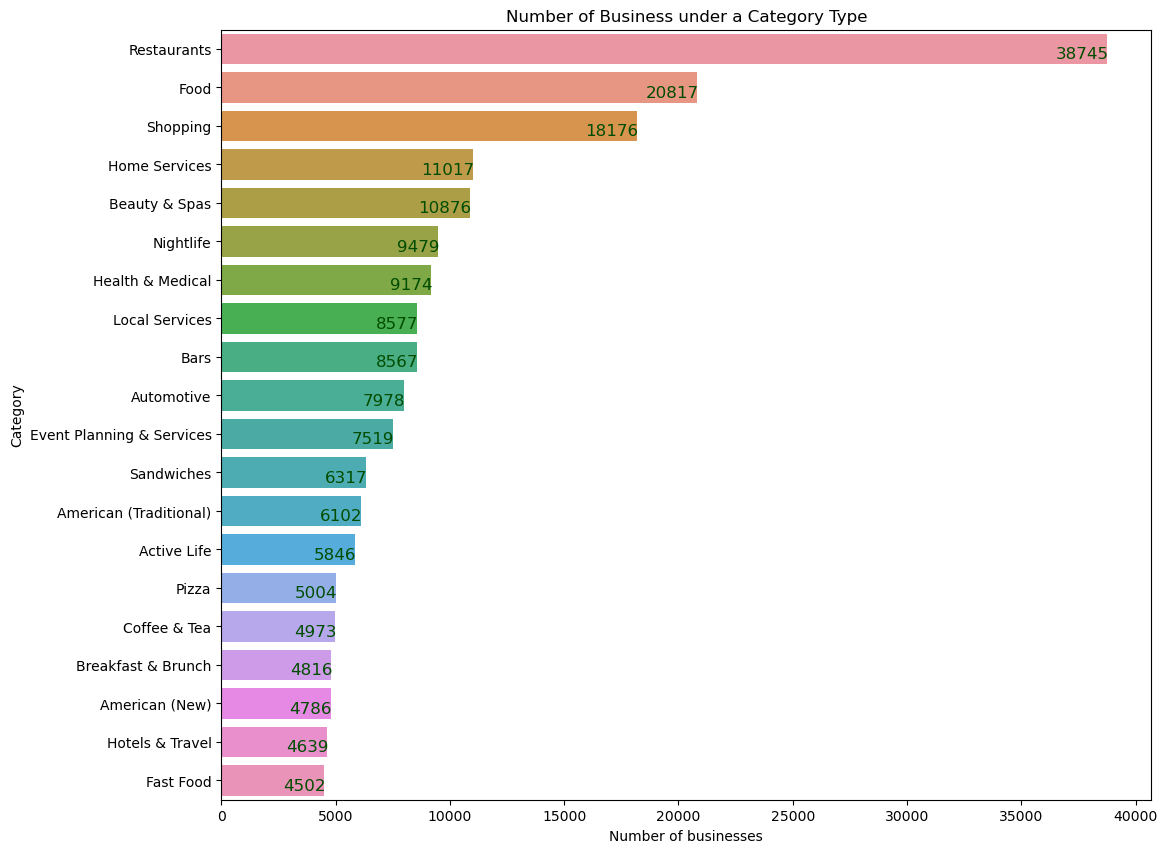

In [7]:
plt.figure(figsize=(12,10))
ax = sns.barplot( y= 'index',x = 'category' , data = cats_df.iloc[0:20])
ax.set_ylabel('Category')
ax.set_xlabel('Number of businesses')
ax.set_title('Number of Business under a Category Type')

for p in ax.patches:
    ax.annotate(int(p.get_width()),
                ((p.get_x() + p.get_width()),
                 p.get_y()),
                 xytext=(1, -18),
                fontsize=12,
                color='#004d00',
                textcoords='offset points',
                horizontalalignment='right')   
plt.show()  

We observe that main category is restaurants. Also, there are other categories that can be related in restaurants as Food, Bars, Sandwicjes, American (traditional), Pizza, Coffee & Tea, American (New) or Fast Food.

Due to this we will create a list of words in categories that can be related with restaurantes. Nevertheless, many if not every business in the dataset, have more than one category, hence, with a small list of restaurant related terms, we will be able to compile every business of such sector.

We include in a list those categories that are related to the restaurant sector, that have 200 or more business with such tag:

In [8]:
restaurant_cat_tags = [
    "Restaurants", "Food", "Bars", "Sandwiches", "American (Traditional)", "Pizza",
    "Coffee & Tea", "Breakfast & Brunch", "American (New)", "Fast Food", "Burgers",
    "Mexican", "Italian", "Specialty Food", "Seafood", "Desserts", "Bakeries", "Salad",
    "Chinese", "Cafes", "Chicken Wings", "Ice Cream & Frozen Yogurt", "Beer", "Sports Bars",
    "Cocktail Bars", "Juice Bars & Smoothies", "Barbeque", "Japanese", "Pubs", "Sushi Bars", 
    "Local Flavor", "Asian Fusion", "Diners", "Steakhouses", "Mediterranean", "Wine Bars", 
    "Vegetarian", "Southern", "Cajun/Creole", "Donuts", "Tacos", "Soup", "Thai", "Beer Bar",    
    "Tex-Mex", "Vegan", "Greek", "Breweries", "Vietnamese", "Chicken Shop", "Hot Dogs", 
    "Indian", "Gluten-Free", "Bagels", "Comfort Food", "Cheesesteaks", "Ethnic Food",
    "Caribbean", "Middle Eastern", "French", "Soul Food", "Buffets", "Gastropubs", 
    "Fruits & Veggies", "Korean", "Bubble Tea", "Tapas/Small Plates", "Food Stands",
    "Cupcakes", "Noodles", "Wineries", "Cuban", "Halal", "Spanish", "Acai Bowls"]



In order to filter the "business_selected_states" dataframe we will use the **isin** function, but it is case sensitive. Hence, we will transform both the list and the variable categories into lowercase.

In [9]:
# Convert the categories column to lowercase
business_selected_states['categories'] = business_selected_states['categories'].str.lower()

# Split the categories column into a list of individual categories, ignoring
# rows where the categories column is None
business_selected_states['categories'] = business_selected_states['categories'].apply(lambda x: x.split(', ') if x is not None else [])

# Convert the restaurant_cat_tags list to lowercase
restaurant_cat_tags = [tag.lower() for tag in restaurant_cat_tags]

# Filter the DataFrame to include only rows where the categories column contains
# at least one value from the restaurant_cat_tags list
restaurants_selected_states = business_selected_states[business_selected_states['categories'].apply(lambda x: any(tag in x for tag in restaurant_cat_tags))]

#Since the index does not start by 0, we reset it
restaurants_selected_states = restaurants_selected_states.reset_index(drop=True)

restaurants_selected_states.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","[restaurants, food, bubble tea, coffee & tea, ...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","[brewpubs, breweries, food]","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","[burgers, fast food, sandwiches, food, ice cre...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."


Now that we have the data we want to use stored under the _restaurants_selected_states_ dataframe, we can focus on the preparation of the variables. Specially on Categories, Attributes and Hours.

##  <a name="3">Variables preparation</a>

###  <a name="3.1">Categories</a>

Now that we have narrow our businesses and the states, it is time to make some variables useful. One of the examples are the column categories, in which we still have a list in every row with the different tags for each business.

In [10]:
df_dummies = pd.get_dummies(restaurants_selected_states['categories'].apply(pd.Series).stack()).sum(level=0)
print("There are " + str(df_dummies.shape[1]) + " unique categories")

There are 848 unique categories


Since the number of different categories is still too high, we will use the list of values used before "restaurant_cat_tags" as the selected ones for our dummy variables.

In [11]:
df_selected_columns = df_dummies.loc[:, restaurant_cat_tags]
df_selected_columns.head()

,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,...,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,1,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [12]:
restaurants_dummies_cat = pd.concat([restaurants_selected_states, df_selected_columns], axis=1, join='inner')
restaurants_dummies_cat.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,halal,spanish,acai bowls
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,1,0,0,0,0,0,0,0,0,0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,0,0,0,0,0,0,0,0,0,0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,0,0,0,0,0,0,0,0,0,0
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,...,0,0,0,0,0,0,0,0,0,0
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,0,0,0,0,0,0,0,0,0,0


###  <a name="3.2">Attributes</a>

Up untill this moment, we have just mentioned the variable attributes, but it contains information relevant for our model. Clients may have into account if the business accepts credit cards or has a parking or terrace for their reviews. 

The information in the variable is stored in a dictionary for each row. Here we face two issues:

 1. Having 39 categories as keys in the dictionaries, they are not always the same for every business, therefore theare are mainly NaN in the values.
 2. The values of such keys are not always True or False. In fact in some cases the response is anither dictionary with more optionas as is rge case for "businessParking".
 
 Thus, first, we will make a dataframe splitting the variable:

In [13]:
attributes = restaurants_selected_states["attributes"].apply(pd.Series)

**Parking Variable**

We observe that parking has also various options, looking also as a dictionary inside the variable. But, this time some rows instead of the dictionary have "None", hence it is recognized as a string.

In order to simplify the column parking we will differenciate two different categories, premium parking and not premium parking. We understand premium parking as Garage or Valet and non premium as Street and lot. If both premium and non premium parking dummies have a 0 value, it would mean that the business does not have a parking.

For validated parking we will not use it since as is denominated seems confusing.

In [14]:
attributes['BusinessParking'] = attributes['BusinessParking'].apply(lambda x: extract_true_values(ast.literal_eval(x)) 
                                                         if isinstance(x, str) else pd.np.nan)

target_words_premium = ['garage', 'valet']
attributes['Premium_Parking'] = attributes['BusinessParking'].apply(lambda x: any(word in x.lower() for word in target_words_premium) if isinstance(x, str) else 0)

target_words_non_premium = ['street', 'lot']
attributes['Non_Premium_Parking'] = attributes['BusinessParking'].apply(lambda x: any(word in x.lower() for word in target_words_non_premium) if isinstance(x, str) else 0)

**Dietary Restrictions Variable**

Similar to the BusinessParking, the dataset has another value with the same forma, DietaryRestrictions. For this column, we will create a variable for each key of the dictionary, being it the 'dairy-free', 'gluten-free', 'vegan', 'kosher', 'halal', 'soy-free', 'vegetarian'.

For the none values, all the elements will be false.

In [15]:
# Replace nan values with a dictionary full of False
default_restrictions = "{'dairy-free': False, 'gluten-free': False, 'vegan': False, 'kosher': False, 'halal': False, 'soy-free': False, 'vegetarian': False}"
attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].apply(
    lambda x: default_restrictions if pd.isna(x) else x)

In [16]:
restrictions = ['dairy-free', 'gluten-free', 'vegan', 'kosher', 'halal', 'soy-free', 'vegetarian']

for restriction in restrictions:
    attributes[restriction] = attributes['DietaryRestrictions'].apply(lambda x: ast.literal_eval(x)[restriction])

In [17]:
attributes = attributes.drop(columns=['DietaryRestrictions'])

The dataset already has the variables vegan, gluten-free, halah and vegetarian. This variables come from the categories. In order to have all food restriction variables come from the same one, the code above will replace those.

**Price Range Variable**

We still have one variable that seems to be subjetive, RestaurantsPriceRange2. We finally decided to keep it since, we consider it is not a fully subjetive variable and can provide useful information towards the model. Looking at its unique values we will transform the 'nan' and 'None' values to the **median** value.

In [18]:
attributes['RestaurantsPriceRange2'].unique()

array(['1', nan, '2', '3', '4', 'None'], dtype=object)

In [19]:
# Convert the None values to nan
attributes['RestaurantsPriceRange2'] = pd.to_numeric(attributes['RestaurantsPriceRange2'], errors='coerce')

# Fill the missing values with the median
attributes['RestaurantsPriceRange2'] = (attributes['RestaurantsPriceRange2'].fillna(
    attributes['RestaurantsPriceRange2'].median())).astype(int)

**Rest of the attributes columns*

There are some cleaning to do to the rest of the attributes variables, for example looking at the Wifi, Alcohol, AgesAllowed and BYOBCorkage values, as some are repeated but with a "u'" at the beggining. 

For the rest the great majority unique values are "True", "False", "None" and "nan". Due to the nature of the columns, We understand that the no or None refers to the fact that the restaurant does not have this service, and in the case of na we understand that it is unknown if the establishment definitely has this service. Knowing this, we translate the na to unknown and the None and no to False.

In [20]:
columns_to_clean = ['Smoking', 'BYOBCorkage', 'AgesAllowed', 'RestaurantsDelivery', 'OutdoorSeating', 
                    'BusinessAcceptsCreditCards',
                     'BikeParking', 'RestaurantsTakeOut', 'ByAppointmentOnly', 'Caters', 'WheelchairAccessible', 'RestaurantsReservations',
                    'CoatCheck', 'DogsAllowed', 'RestaurantsTableService', 'HasTV', 'HappyHour', 'DriveThru',
                     'BusinessAcceptsBitcoin', 'AcceptsInsurance', 'RestaurantsCounterService', 'RestaurantsDelivery', 
                    'Alcohol', 'WiFi']

for column in columns_to_clean:
# Deletes de "u'" values
  attributes[column] = attributes[column].str.replace("u'", "").str.replace("'", "")
# Replace the None values with False
  attributes[column] = attributes[column].replace("None", "False")  
# Replace the none values with False
  attributes[column] = attributes[column].replace("none", "False")    
# Fill the nan values with unknown
  attributes[column] = attributes[column].fillna("unknown")
# Replace the no values with False
  attributes[column] = attributes[column].replace("no", "False")

Finally, we drop BYOB and Corgkage variables as the information they provide is also in the variable BYOBcorkage

In [21]:
attributes = attributes.drop(columns=['BYOB','Corkage'])


**Dropping Subjetive variables**

We also can observe some attributes that might me subjetive as it is "goodforgroups" or "Noise". In order to keep the data as objetive as possible, we will drop them.

In [22]:
attributes = attributes.drop(columns=['BusinessParking','GoodForKids','RestaurantsAttire', 'Ambience',
                                      'RestaurantsGoodForGroups','NoiseLevel', 'GoodForDancing',
                                      'GoodForMeal', 'BestNights', 'Music', 'HairSpecializesIn'])
attributes.head()

,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,...,AgesAllowed,Premium_Parking,Non_Premium_Parking,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
0,False,False,False,True,1,True,False,free,False,True,...,unknown,False,True,False,False,False,False,False,False,False
1,unknown,unknown,True,True,2,True,unknown,unknown,unknown,False,...,unknown,False,True,False,False,False,False,False,False,False
2,True,True,True,False,1,True,False,False,False,False,...,unknown,False,False,False,False,False,False,False,False,False
3,False,True,True,unknown,1,True,unknown,free,full_bar,True,...,unknown,False,True,False,False,False,False,False,False,False
4,True,True,True,unknown,1,True,False,False,False,False,...,unknown,False,False,False,False,False,False,False,False,False


After obtaining the desirable attributes, we realized that in categories we also have some columns that come from categories that identify if the restaurant is vegan, gluten-free, vegetarian or halal. We understand that is better to have all the dietary restrictions comming from the same source, hence we will drop them. 

The, we include the attributes columns in the dataframe with the rest of the business information. 

In [23]:
pd.options.display.max_columns = 200
columns_to_drop = ['vegetarian', 'vegan', 'gluten-free', 'halal' ]
restaurants_dummies_cat = restaurants_dummies_cat.drop(columns_to_drop, axis=1)
restaurants = pd.concat([restaurants_dummies_cat, attributes], axis=1).drop(columns=["attributes", "categories"])
restaurants.tail(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,greek,breweries,vietnamese,chicken shop,hot dogs,indian,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,spanish,acai bowls,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,WheelchairAccessible,RestaurantsReservations,CoatCheck,DogsAllowed,RestaurantsTableService,HasTV,HappyHour,DriveThru,BusinessAcceptsBitcoin,Smoking,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,Premium_Parking,Non_Premium_Parking,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian
50171,cM6V90ExQD6KMSU3rRB5ZA,Dutch Bros Coffee,1181 N Milwaukee St,Boise,ID,83704,43.615401,-116.284689,4.0,33,1,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-17:0', '...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,True,True,1,False,unknown,free,False,False,unknown,False,unknown,unknown,unknown,False,unknown,unknown,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False
50172,1jx1sfgjgVg0nM6n3p0xWA,Savaya Coffee Market,11177 N Oracle Rd,Oro Valley,AZ,85737,32.409552,-110.943073,4.5,41,1,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-14:0', '...",0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,True,True,2,True,unknown,free,unknown,False,True,unknown,unknown,False,unknown,unknown,unknown,unknown,False,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False
50173,WnT9NIzQgLlILjPT0kEcsQ,Adelita Taqueria & Restaurant,1108 S 9th St,Philadelphia,PA,19147,39.935982,-75.158665,4.5,35,1,"{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,False,True,True,2,True,unknown,free,False,True,False,False,unknown,unknown,True,True,False,unknown,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False


###  <a name="3.3">Hours</a>

For the variable hour we will be using the functions afore defined. With this functions we will obtain two new variables. 

The first one, **num_days_open**, will yield the number of days a week the business is open.

The last one, **num_hours_open**, will yield the number of hours a week the business is open.

In [24]:
restaurants['num_days_open'] = restaurants['hours'].apply(count_days)
restaurants['num_hours_open'] = restaurants['hours'].apply(count_hours)
restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,hours,restaurants,food,bars,sandwiches,american (traditional),pizza,coffee & tea,breakfast & brunch,american (new),fast food,burgers,mexican,italian,specialty food,seafood,desserts,bakeries,salad,chinese,cafes,chicken wings,ice cream & frozen yogurt,beer,sports bars,cocktail bars,juice bars & smoothies,barbeque,japanese,pubs,sushi bars,local flavor,asian fusion,diners,steakhouses,mediterranean,wine bars,southern,cajun/creole,donuts,tacos,soup,thai,beer bar,tex-mex,greek,breweries,vietnamese,chicken shop,hot dogs,indian,bagels,comfort food,cheesesteaks,ethnic food,caribbean,middle eastern,french,soul food,buffets,gastropubs,fruits & veggies,korean,bubble tea,tapas/small plates,food stands,cupcakes,noodles,wineries,cuban,spanish,acai bowls,RestaurantsDelivery,OutdoorSeating,BusinessAcceptsCreditCards,BikeParking,RestaurantsPriceRange2,RestaurantsTakeOut,ByAppointmentOnly,WiFi,Alcohol,Caters,WheelchairAccessible,RestaurantsReservations,CoatCheck,DogsAllowed,RestaurantsTableService,HasTV,HappyHour,DriveThru,BusinessAcceptsBitcoin,Smoking,BYOBCorkage,AcceptsInsurance,RestaurantsCounterService,Open24Hours,AgesAllowed,Premium_Parking,Non_Premium_Parking,dairy-free,gluten-free,vegan,kosher,halal,soy-free,vegetarian,num_days_open,num_hours_open
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,False,False,False,True,1,True,False,free,False,True,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False,7.0,94.0
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...",0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,unknown,unknown,True,True,2,True,unknown,unknown,unknown,False,True,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False,5.0,40.0
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...",1,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,True,False,1,True,False,False,False,False,True,False,False,False,False,True,False,True,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,False,False,False,False,False,False,False,False,6.0,66.0
3,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,None,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,False,True,True,unknown,1,True,unknown,free,full_bar,True,unknown,False,unknown,unknown,unknown,True,unknown,unknown,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,True,False,False,False,False,False,False,False,NaN,NaN
4,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...",1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,True,True,True,unknown,1,True,False,False,False,False,True,False,False,False,False,True,False,True,unknown,unknown,unknown,unknown,unknown,NaN,unknown,False,False,False,False,False,False,False,False,False,6.0,76.0


Since we have a varibale called Open24Hours, is duplicating the data, for that reason as since num_days_open and num_hours_open gives more information, we will drop the Open24Hours variable as well as the hours one.

In [25]:
restaurants = restaurants.drop(columns=['Open24Hours', 'hours'])

##  <a name="4">Star Variable modification</a>

**Star variable**

First thing we have to modify is our current star variable. As we stated before we are interesting in those restaurans with four or more stars in their average review. For this reason **we will transform this column into 1s and 0s. Being the 1s those restaurants with a higher star count (≥4) and the 0s for the rest (<4).**

In [26]:
#first we check is there is NA
sum(restaurants["stars"].isna())

0

In [27]:
#After loking there are no NA, we proceed to do the transformation.
# Transform the 'stars' column
restaurants['stars'] = restaurants['stars'].apply(lambda x: 1 if x >= 4.0 else 0)

In [28]:
print("The proportion of successfull restaurants in the dataset (four or more stars) is " +
      str(round(100*sum(restaurants['stars'])/len(restaurants['stars']),2)) +"%")

The proportion of successfull restaurants in the dataset (four or more stars) is 47.67%


As of right now, the variables we will encode are those we have substarct from Attributes and Categories. For the rest of the variables we will deal with them at the EDA (the next notebook).

In [31]:
pd.options.display.max_rows = 50

selected_columns = restaurants.iloc[:, 82:]
# Get the unique values in the selected columns
print(selected_columns.apply(lambda x: x.unique()))

RestaurantsDelivery                                      [False, unknown, True]
OutdoorSeating                                           [False, unknown, True]
BusinessAcceptsCreditCards                               [False, True, unknown]
BikeParking                                              [True, False, unknown]
RestaurantsPriceRange2                                             [1, 2, 3, 4]
RestaurantsTakeOut                                       [True, unknown, False]
ByAppointmentOnly                                        [False, unknown, True]
WiFi                                               [free, unknown, False, paid]
Alcohol                               [False, unknown, full_bar, beer_and_wine]
Caters                                                   [True, False, unknown]
WheelchairAccessible                                     [unknown, True, False]
RestaurantsReservations                                  [unknown, False, True]
CoatCheck                               

We do not observe values in the variables that are outside the normal. During the EDA notebook we will take a look at how we will treat the nan and None values depending on the variable. 

**postal_code type**

Before exporting our data, we will need to change the type of the variable postal_code as right now is as float. Due to its characteristics and as is usually done, we will change its type to string. 

In [ ]:
restaurants['postal_code'] = restaurants['postal_code'].astype(str)

##  <a name="4">Selected Data Export</a>

In [ ]:
restaurants.info()

Since the resulting data is way too big we exported it to a CSV file, in the folder processed within data. 

In [ ]:
restaurants.to_csv('../data/processed/restaurants.csv', index=False)